In [1]:
# Jonny tf runs
import numpy as np
from framework import *
%load_ext autoreload
%autoreload 2

As an example, we will illustrate this framework using the toy spiral
dataset (taken from Karpathy). It can be generated and visualized as follows

Since we know the distribution and can easily visualize it,
we will not use a training/test split, regularization, or 
batches (the set is only 400 long). Those will be illustrated in
a future implementation. We now show how easily we can train a two-layer neural network to fit the above dataset.

All sessions must begin with the Graph() instantiation, which resets the current computation graph. We then write in all of the variables, and the corresponding operations on those variables. We keep placeholders for input data X and y that changes during training. Variables are the parameters of the model that will be trained. Constants are just constants. They are not trained, or changed in any way once specified.

In [2]:
N = 100 # number of points per class
D = 2 # dimensionality
K = 4 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*(K+1),(j+1)*(K+1),N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
print("The data is of size")
print("X:",X.shape, ", y",y.shape)
print('-'*60)

The data is of size
X: (400, 2) , y (400,)
------------------------------------------------------------


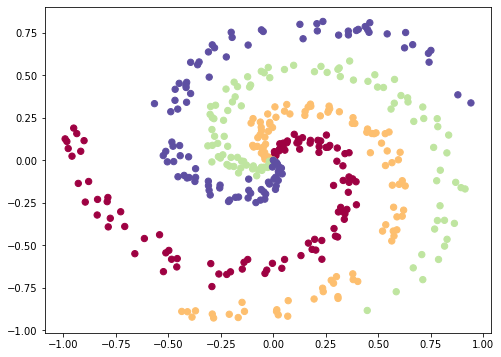

In [3]:
# visualize the data:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (8.0, 6.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

To build a neural net, we follow the following steps:

1. Run g=Graph(). This instantiates the compmutation graph.
2. Write in all layers, and label them by their output.
3. (optional) visualize the computation graph via g.make_graph
4. To compute, open a session via sess=Session().
    a) compute nodes in forward pass via sess.forward(target_node) (argument is optional)
    b) compute backward pass via sess.backward(target_node) (argument is optional)
5. Train via looping over forward/backward pass and updating variables
6. Predict via calling sess.forward and according to appropriate loss function.

In [4]:
# initialize graph
g = Graph()

# write steps of neural net. Important, we must make sure
# all placeholders have the same name as they do in feed_dict
H = 20
X_train = Placeholder('X')
W1 = Variable(np.random.randn(2,H), 'W1')
W2 = Variable(np.random.randn(H,K), 'W2')
b1 = Variable(np.zeros(H), 'b1')
b2 = Variable(np.zeros(K), 'b2')
y_train = Placeholder('y')
z1 = affine(X_train, W1, b1, name='z1')
a1 = relu(z1, name='a1')
scores = affine(a1, W2, b2, name='scores')
J = softmax_loss(scores, y_train)

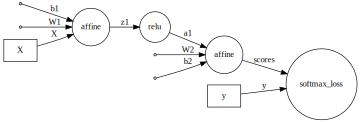

In [5]:
# The Graph class has a method make_graph that may be used to 
# produce a computation graph. Circular nodes are operators and the 
# arrows describe incoming/outgoing weights/constants/layers.
# placeholders are given by box nodes, and usually represent locations
# where we insert data
g.make_graph()

In [6]:
# We now open up a session, taking the current graph as input
sess = Session(g)
# During intialization, Session automtically topologically sorts the graph
# saving it into class variable Session().order
print(sess.order)

[X, W1, b1, z1, a1, W2, b2, scores, y, softmax_loss]


In [7]:
feed_dict = {'X':X, 'y':y}
loss_history = []
num_iters = 3000
print_every = 100
for i in range(num_iters):
    loss = sess.forward(feed_dict=feed_dict)
    loss_history.append(loss)
    sess.backward()
    sess.update(lr=5e-1)
    if i % print_every == 0:
        print(f"iteration {i}/{num_iters}. Loss = {loss}")

iteration 0/3000. Loss = 2.2702869513916593
iteration 100/3000. Loss = 0.8583174773563786
iteration 200/3000. Loss = 0.665367295030409
iteration 300/3000. Loss = 0.5371902904997041
iteration 400/3000. Loss = 0.4560271802887163
iteration 500/3000. Loss = 0.4005799337009378
iteration 600/3000. Loss = 0.3537005254502754
iteration 700/3000. Loss = 0.31429444924611827
iteration 800/3000. Loss = 0.28502134940783075
iteration 900/3000. Loss = 0.254325057977683
iteration 1000/3000. Loss = 0.23195899503461706
iteration 1100/3000. Loss = 0.21411037594310958
iteration 1200/3000. Loss = 0.19917436155683688
iteration 1300/3000. Loss = 0.1860187719847034
iteration 1400/3000. Loss = 0.17437168680176163
iteration 1500/3000. Loss = 0.16428249419460772
iteration 1600/3000. Loss = 0.15625466623517942
iteration 1700/3000. Loss = 0.14705383868738742
iteration 1800/3000. Loss = 0.13973670143107442
iteration 1900/3000. Loss = 0.13218946601138312
iteration 2000/3000. Loss = 0.12614519121746195
iteration 2100/

Text(0, 0.5, 'Loss')

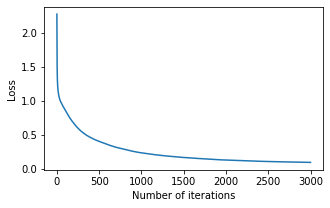

In [8]:
plt.figure(figsize=(5,3))
plt.plot(loss_history)
plt.xlabel('Number of iterations')
plt.ylabel('Loss')

To see how our neural net classifies points, we generate an ensemble
of points below, and ask the net to classify them. This is compared side by side with the original data.

We use the predict function, which simply cuts off the forward pass
at "scores", then returns the class with the highest score

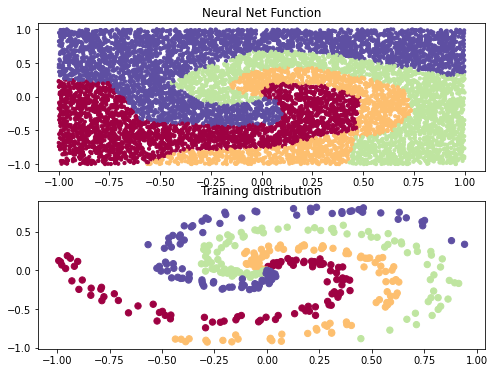

In [9]:
## prediction function for analyzing net
def predict(x):
    feed_dict = {'X':x}
    scrs = sess.forward(head_node=scores, feed_dict=feed_dict)
    return np.argmax(scrs, axis=1)

# Generate random points in the plane
npts=10000
X_rand = 2*np.random.rand(npts,2)-1
color = np.argmax(sess.forward(scores, feed_dict={'X':X_rand,'y':y}), axis=1)

# plot neural network predictions
plt.subplot(2,1,1)
plt.scatter(X_rand[:, 0], X_rand[:, 1], c=color, s=10, cmap=plt.cm.Spectral)
plt.title('Neural Net Function')

# plot the original dataset
plt.subplot(2,1,2)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.title('Training distribution')

plt.show()